In [1]:
import os
import pydot
import numpy as np
import soundfile as sf
import tensorflow as tf
import matplotlib.pyplot as plt
from ast import literal_eval
from scipy import signal
from scipy.interpolate import interp1d
from scipy.io import wavfile

In [2]:
def hann_window(N):
    # Definición de la ventana hamming de modo que se pueda generar para un
    # largo de ventana definido
    return np.asarray([0.5 - 0.5*np.cos((2*np.pi*i)/N)
                       for i in range(int(N))])


def downsampling_signal(signal_in, samplerate, freq_pass, freq_stop, 
                        method='lowpass', lp_method='fir',
                        resample_method='interp1d',
                        fir_method='kaiser', gpass=1, gstop=80,
                        correct_by_gd=True, gd_padding='periodic',
                        plot_filter=False, normalize=True):
    '''Función que permite disminuir la cantidad de muestras por 
    unidad de tiempo de una señal dada, en función de la frecuencia
    de corte para el pasabajo. Es decir, dada una frecuencia de corte
    de interés, se resampleará la señal al doble de esa frecuencia.
    
    Parameters
    ----------
    signal_in : list or ndarray
        Señal a submuestrear.
    samplerate : int
        Tasa de muestreo de la señal "signal_in".
    freq_pass : float
        Frecuencia de corte de la pasa banda.
    freq_stop : float
        Frecuencia de corte de la rechaza banda. Esta es la que se toma
        en cuenta al momento de hacer el último corte (por ende, si 
        busca samplear a 2kHz, seleccione este parámetro en 1kHz).
    method : {'lowpass', 'cut'}, optional
        Método utilizado para filtrar la señal. Para 'lowpass', se aplica un filtro pasabajos 
        para evitar aliasing de la señal, luego se submuestrea. Para 'cut', se corta en la 
        frecuencia de interés. Por defecto es 'lowpass'.
    lp_method : {'fir', 'iir', 'cut'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. 'cut' es un método no convencional en el que
        se todas las frecuencias filtradas de la magnitud se hacen 0. Por defecto es 'fir'.
    resample_method : {'resample', 'resample poly', 'interp1d', 'decimation'}, optional
        Método usado para resamplear. Para 'resample', se aplica la función resample de scipy.
        Para 'resample_poly', se aplica la función resample_poly de scipy. Para 'interp1d',
        se aplica la función 'interp1d' de scipy. Y para 'decimation' se  realiza una 
        decimación a la señal por un parámetro "N_dec" obtenido automáticamente. Por defecto 
        es 'interp1d'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de construcción del filtro FIR en caso de seleccionar el método lowpass con 
        filtro FIR. Para 'window', se usa construye por método de la ventana. Para 'kaiser',
        se cosntruye por método de ventana kaiser. Para 'remez', se construye por algoritmo 
        remez. Por defecto se usa 'kaiser'.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    correct_by_gd : bool, optional. 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    plot_filter : bool
        Activar ploteo del filtro aplicado.
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
    
    Referencias
    -----------
    [1] https://www.cppsim.com/BasicCommLectures/lec10.pdf
    '''
    # Se calcula el paso de la decimación
    N_dec = round(samplerate / (freq_stop * 2))
    
    # Calculo de la nueva tasa de muestreo
    new_rate = 2 * freq_stop
    
    # Selección del método del pasabajos
    if method == 'lowpass':
        # Aplicando el filtro pasa bajos
        _, signal_lp = lowpass_filter(signal_in, samplerate, freq_pass, 
                                      freq_stop, method=lp_method, 
                                      fir_method=fir_method, gpass=gpass, 
                                      gstop=gstop, plot_filter=plot_filter,
                                      correct_by_gd=correct_by_gd,
                                      gd_padding=gd_padding,
                                      normalize=normalize)
    elif method == 'cut':
        signal_lp = lowpass_cut_frequency(signal_in, samplerate, 
                                          freq_stop)
    else:
        raise Exception('Opción de método no válido. Por favor, ingrese'
                        ' un valor válido.')
    
    # Selección del método de resampleo
    if resample_method == 'resample':
        return new_rate, signal.resample(signal_lp, 
                                         len(signal_lp)//N_dec)
    
    elif resample_method == 'resample_poly':
        return new_rate, signal.resample_poly(signal_lp, 
                                              len(signal_lp)//N_dec, 1)
    
    elif resample_method == 'interp1d':
        # Vector de referencia en el eje "x" del vector original
        x = np.arange(0, len(signal_lp))
        
        # Vector de referencia en el eje "x" del vector de salida
        x_new = np.linspace(0, len(signal_lp) - 1, len(signal_lp)//N_dec)
        
        # Creación de la función que realiza la interpolación
        f = interp1d(x, signal_lp)

        return new_rate, f(x_new)
    
    elif resample_method == 'decimation':
        # Calculo de la nueva tasa de muestreo
        new_rate = samplerate // N_dec
        
        return new_rate, decimation_signal(signal_lp, N_decimate=N_dec)

                     
def lowpass_filter(signal_in, samplerate, freq_pass, freq_stop,
                   method='fir', fir_method='kaiser', gpass=1, 
                   gstop=80, plot_filter=False, correct_by_gd=True,
                   gd_padding='periodic', normalize=True):
    '''Función que permite crear un filtro pasabajos con una frecuencia
    de corte ingresada por el usuario el cual se aplicará a la señal de
    entrada de la función.
    
    Parámetros
    - signal: Señal a filtrar
    - samplerate: Tasa de muestreo de la señal utilizada
    - freq_pass: Frecuencia de corte de la pasa banda
    - freq_stop: Frecuencia de corte de la rechaza banda
    - cutoff_freq: Frecuencia de corte en radianes (pi representa fs/2)
    - method: Método de filtrado
        - ['fir']: Se implementa mediante un filtro fir
        - ['iir']: Se implementa mediante un filtro iir
        - ['cut']: Se implementa simplemente cortando en la frecuencia de interés
    - fir_method: Método de construcción del filtro FIR
        - ['window']: Construcción por método de la ventana
        - ['kaiser']: Construcción por método de ventana kaiser
        - ['remez']: Construcción por algoritmo remez
    - gpass: Ganancia en dB de la magnitud de la pasa banda
    - gstop: Ganancia en dB de la magnitud de la rechaza banda
    - plot_filter: Booleano que permite graficar la señal a ifiltrar y el filtro
    - correct_by_gd: Booleano que permite corregir la salida del filtro FIR por su
                     retraso de grupo
    - gd_padding: Formato para el padding de la señal de entrada
        - [None]: No se hace padding
        - ['zero']: Se hace padding con "len(signal_in)" ceros a la izquierda y
                    derecha de la señal
        - ['periodic']: Se hace padding copiando la señal 3 veces
        - ['constant']: Se hace padding copiando el primer y el último valor para
                        el caso de la izquierda y la derecha respectivamente
    - normalize: Normalización de la señal de salida
    '''
    # Obtención de los parámetros para cada método
    if method == 'fir':
        num = fir_filter_adapted(freq_pass, freq_stop, samplerate, gpass=gpass,
                                 gstop=gstop, use_exact=True, method=fir_method,
                                 print_window=plot_filter, apply_firwin=False)
        den = 1
        
        # Definición gd
        _, gd_list = signal.group_delay((num, den))
        
        gd = round(np.mean(gd_list))
        
        
    elif method == 'iir':
        num, den = signal.iirdesign(wp=freq_pass / (samplerate/2),
                                    ws=freq_stop / (samplerate/2),
                                    gpass=gpass, gstop=gstop)
        # Se define de facto el padding en None ya que es solo una función para
        # filtros FIR
        gp_padding = None
        
        # Se define correct_by_gd en False ya que no se utilizará en algún caso
        correct_by_gd = False
        
        # Definición gd (ya que su fase no es lineal)
        gd = None
        
    elif method == 'cut':
        signal_filtered =  lowpass_cut_frequency(signal_in, samplerate, 
                                                 freq_stop)
        
        # Se define no plotear dado que no hay filtro (independiente de la entrada)
        plot_filter = False
        
        # Se define de facto el padding en None ya que es solo una función para
        # filtros FIR
        gp_padding = None
        
        # Se define correct_by_gd en False ya que no se utilizará en algún caso
        correct_by_gd = False
        
        # Definición gd (ya solo hay corte, no desfase)
        gd = 0
        
        # Definición de salida num y den
        num = den = None
    
    # Opción corregir por delay de grupo (solo para FIR)
    if correct_by_gd:
        signal_to_filt, signal_filtered =\
            filt_and_correct_group_delay(signal_in, gd, gd_padding, num, den)
    else:
        if method != 'cut':
            # Definición de la señal a filtrar
            signal_to_filt = signal_in
            
            # Filtrando
            signal_filtered = signal.lfilter(num, den, signal_to_filt)
    
    if plot_filter:        
        # Subplot principal para los 2 gráficos
        _, ax = plt.subplots(2,1)
        
        # Graficando la señal
        ax[0].set_title('Señal a filtrar')
        ax[0].plot(signal_to_filt)
        
        # Y obteniendo la función de transferencia h
        w, h = signal.freqz(num, den)
        # Graficando el filtro
        ax[1].set_title('Respuesta en frecuencia del filtro digital')
        magnitude = 20 * np.log10(abs(h))
        ax[1].plot(w, magnitude, 'r')
        ax[1].set_ylabel('Magnitude [dB]', color='r')
        ax[1].set_xlabel('Frequencia [rad/sample]')
        ax[1].set_ylim([min(magnitude), max(magnitude) + 10])
        ax2 = ax[1].twinx()
        angles = np.unwrap(np.angle(h))
        ax2.plot(w, angles, 'b')
        ax2.set_ylabel('Phase (radians)', color='b')
        ax2.axis('tight')
        ax2.set_ylim([min(angles), max(angles)])
        plt.show()
    
    if normalize:
        return (gd, num, den), signal_filtered / max(abs(signal_filtered))
    else:
        return (gd, num, den), signal_filtered


def fir_filter_adapted(freq_pass, freq_stop, samplerate, gpass=1,
                       gstop=80, use_exact=True, print_window=True,
                       fir_type='lowpass', method='window', parity='odd', 
                       apply_firwin=False):
    '''Diseño de filtros FIR mediante el método de ventaneo. Esta 
    función retorna los coeficientes h[n] del filtro en el tiempo.
    Este filtro minimiza el orden del filtro seleccionando la 
    ventana más conveniente en base a la declaración en decibeles
    de la ganancia de la rechaza banda.
    
    Parameters
    ----------
    freq_pass : float
        Frecuencia de corte de la pasa banda.
    freq_stop : float
        Frecuencia de corte de la rechaza banda.
    samplerate: int 
        Tasa de muestreo de la señal utilizada.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    use_exact : bool, optional
        Booleano que indica si se usa el valor exacto de transición entre bandas 
        (delta omega). Por defecto es True
    print_window : bool, optional.
        Si se imprime la ventana seleccionada y su orden. Por defecto es False.
    fir_type : {'lowpass', 'highpass'}, optional
        Filtro FIR a crear, que puede ser pasa bajo o pasa alto. Por defecto es 'lowpass'.
    method : {'window', 'kaiser', 'remez'}, optional
        Método de aplicación del filtro FIR. 'window'es construcción por método de la ventana,
        'kaiser' es construcción por método de ventana kaiser y 'remez' es construcción por 
        algoritmo remez. Por defecto es 'kaiser'.
    parity : {'odd', 'even'}, optional
        Cantidad par o impar de puntos para el filtro. Por defecto es 'odd'.
    apply_firwin : bool, optional
        Si se aplica la función firwin o si se hace manualmente. Por defecto es False.
    
    Returns
    -------
    h_n : ndarray
        Ventana del filtro deseado.
    
    Referencias:
    [1] Digital Signal Processing: Principles, Algorithms, and 
        Applications by J. G. Proakis and D. G. Manolakis.
    [2] Página CCRMA de Julius O. Smith III, disponible en:
        https://ccrma.stanford.edu/~jos/
    '''
    # Definición de los ripples en escala absoluta [1]
    delta_p = (10**(gpass/20) - 1)/(10**(gpass/20) + 1)
    delta_s = (1 + delta_p)/(10**(gstop/20))
    # Se escoge el mínimo delta para el diseño de la
    # ganancia A [1]
    delta = min(delta_p, delta_s)
    
    # Definición de ganancia límite
    A = -20*np.log10(delta) 
    
    # Definición de la frecuencia de corte
    cutoff_freq = (freq_pass + freq_stop) / 2
    # Definición de la frecuencia central angular
    omega_c = 2 * np.pi * cutoff_freq / samplerate
    
    # Definición del ancho de banda delta omega 
    trans_width = abs(freq_pass - freq_stop)
    # Definición del ancho de banda delta omega angular
    band_w = 2 * np.pi * trans_width / samplerate
    
    # Para el procedimiento del filtro FIR mediante ventaneo
    if method == 'window':
        # Definición de las ventanas
        windows = (('rectangular', 21, 4 * np.pi, 1.8 * np.pi),
                   ('bartlett', 26, 8 * np.pi, 6.1 * np.pi),
                   ('hann', 44, 8 * np.pi, 6.2 * np.pi),
                   ('hamming', 53, 8 * np.pi, 6.6 * np.pi),
                   ('blackman', 71, 12 * np.pi, 11 * np.pi))

        # Selección de la ventana
        index_window = np.argmin([abs(i[1] - A) for i in windows])

        # Definición de la ventana elegida
        window_choose = windows[index_window][0]
        
        # Una vez seleccionada la ventana, se escoge el orden del filtro,
        # procurando que el ancho del lóbulo principal no sea más grande
        # que la frecuencia de corte [1][2]
        delta_w = 3 if use_exact else 2
        L = round(windows[index_window][delta_w] / band_w)

        # Definición del orden del polinomio de la función de trans-
        # ferencia (largo del filtro). Mientras que L es el largo de
        # la respuesta al impulso
        M = L - 1
        
    # Para el procedimiento mediante ventana kaiser
    elif method == 'kaiser':
        # Definición de la ventana elegida
        window_choose = 'kaiser' 
        
        # Cálculo del beta
        beta = beta_kaiser(A)
        
        # Estimación del orden del filtro [1]
        M = int(np.ceil((A - 8) / (2.285 * band_w)))
    
    # Para el procedimiento mediante algoritmo remez
    elif method == 'remez':
        # El orden del filtro está dado por la relación empírica 
        # propuesta por Kaiser
        M = (-20*np.log10(np.sqrt(delta_s*delta_p)) - 13)/(2.324*band_w)
        # Definición del parámetro de construcción de la ventana
        K = delta_p/delta_s
        
        # Especificación del filtro
        M = int(np.ceil(M))
        M = M  if M % 2 == 0 else M + 1
        
        # Se define el set de frecuencias crítico para el algotitmo
        # el cual contiene [0, wp, ws, pi], donde todas son divididas
        # en 2*pi (se expresan en "f").
        fo = [0, freq_pass, freq_stop, samplerate/2]
        
        # Este vector contiene los valores que tomarán las amplitudes de
        # las frecuencias de interés definidas anteriormente (cada una 
        # representa un rango, por ejemplo entre 0 y freq_pass -> 1  
        # y entre  freq_stop y samplerate/2 -> 0)
        ao = [1, 0]
        
        # Corresponde a los valores que toma la función W(omega) para 
        # cada banda
        W = [1, K]
        
        # Aplicando entonces Parks-McClellan
        return signal.remez(M + 1, fo, ao, W, fs=samplerate)
    
    # OJO: La opción paridad tiene directa relación con el largo de la 
    # salida L, no con M. Por ende, para 'odd', se hará M par para que
    # L sea impar (y viceversa, ya que L = M + 1).
    if parity == 'odd':
        # Si es que M es par, mantenerlo par, si es que es impar, 
        # sumar 1 (esto para L, no para M)
        M = M if M % 2 == 0 else M + 1
    
    elif parity == 'even':
        # Si es que M es impar, mantenerlo impar, si es que es par, 
        # sumar 1 (esto para L, no para M)
        M = M if M % 2 != 0 else M + 1
    
    else:
        raise Exception('Opción de paridad no válida.')
    
    # Redefiniendo L
    L = M + 1
    
    if print_window:
        print(f'Ventana: {window_choose}\n'
              f'Largo resp. al impulso: {L}')
    
    # Aplicando el filtro
    if apply_firwin:
        if window_choose == 'kaiser':
            window_choose = ('kaiser', beta)
            
        return signal.firwin(L, cutoff_freq, 
                             window=window_choose,
                             pass_zero=fir_type,
                             fs=samplerate)
    else:
        # Selección de ventana
        if window_choose == 'rectangular':
            window = np.ones(L)
        elif window_choose == 'bartlett':
            window = np.bartlett(L)
        elif window_choose == 'hann':
            window = np.hanning(L)
        elif window_choose == 'hamming':
            window = np.hamming(L)
        elif window_choose == 'blackman':
            window = np.blackman(L)
        elif window_choose == 'kaiser':
            window = np.kaiser(L, beta)
        
        # Definición de la respuesta al impulso del filtro pasabajo 
        # ideal
        hd = lambda n: (np.sin(omega_c*(n - M/2))/(np.pi*(n - M/2)))\
                        if (n != M/2) else omega_c/np.pi
        
        # Calculando
        hd_n = np.asarray([hd(i) for i in range(L)])
        return  hd_n * window

                     
def beta_kaiser(A):
    '''Función por tramos que indica el valor que debe tomar el
    parámetro beta
    
    Parámetros
    - A: Ganancia máxima entre ripple de pasa banda y rechaza 
         banda obtenido anteriormente mediante la parametrización
         
    Referencias
    [1] Digital Signal Processing: Principles, Algorithms, and 
        Applications by J. G. Proakis and D. G. Manolakis.
    '''
    if A < 21:
        return 0
    elif 21 <= A <= 50:
        return 0.5842 * (A - 21) ** 0.4 + 0.07886 * (A - 21)
    else:
        return 0.1102 * (A - 8.7)


def filt_and_correct_group_delay(signal_in, gd, gd_padding, num, den):
    '''Función que permite realizar el proceso de filtrado y de corrección por
    delay de grupo a una señal a filtrar.
    
    Parameters
    ----------
    signal_in : ndarray
        Señal a filtrar y corregir.
    gd : int or float
        Delay de grupo de la señal.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    num : int, float, list or ndarray
        Coeficientes del numerador para el filtro.
    den : int, float, list or ndarray
        Coeficientes del denominador para el filtro.
    
    Returns
    -------
    signal_to_filt : ndarray
        Señal que se utiliza para filtrar considerando el gd_padding.
    signal_filtered : ndarray
        Señal filtrada y corregida por el delay de grupo.
    '''
    # Presentación de la señal de entrada
    if gd_padding is None:
        signal_to_filt = signal_in

    elif gd_padding == 'zero':
        signal_to_filt = np.concatenate(([0] * len(signal_in),
                                         signal_in,
                                         [0] * len(signal_in)))
    elif gd_padding == 'periodic':
        signal_to_filt = np.concatenate((signal_in,
                                         signal_in,
                                         signal_in))
    elif gd_padding == 'constant':
        signal_to_filt = np.concatenate(([signal_in[0]] * len(signal_in),
                                         signal_in,
                                         [signal_in[-1]] * len(signal_in)))
    else:
        raise Exception('Opción de padding no disponible. Por favor, intente '
                        'nuevamente')

    # Para poder filtrar el audio
    signal_filtered = signal.lfilter(num, den, signal_to_filt)

    # Si se hace padding, se debe cortar de tal forma que se logre sincro-
    # nizar la señal de entrada en función del delay de grupo
    if gd_padding is not None:
        delay = gd
        
        # Definición de los índices a considerar. Se escogen estos índices
        # ya que se asume que el comportamiento ideal de la señal 3 veces
        # paddeada, se encuentra en el centro del arreglo
        ini_index = int(len(signal_in) + delay)
        end_index = int(2 * len(signal_in) + delay)

        # Recortando
        signal_filtered = signal_filtered[ini_index:end_index]

    return signal_to_filt, signal_filtered


def upsampling_signal(signal_in, samplerate, new_samplerate,
                      N_desired=None, resample_method='interp1d',
                      stret_method='lowpass', lp_method='fir', 
                      fir_method='kaiser', trans_width=50, gpass=1, gstop=80, 
                      correct_by_gd=True, gd_padding='periodic',
                      plot_filter=False, plot_signals=False,
                      normalize=True):
    '''Función que permite aumentar la cantidad de muestras por 
    unidad de tiempo de una señal dada, en función de la nueva tasa
    de muestreo deseada.
    
    Parameters
    ----------
    signal_in : list or ndarray
        Señal a submuestrear.
    samplerate : int
        Tasa de muestreo de la señal "signal_in".
    new_samplerate : int
        Tasa de muestreo deseada de la señal.
    N_desired : int or NoneType, optional
        Cantidad de puntos deseadas en la señal de salida. Por defecto es None.
    resample_method : {'resample', 'resample poly', 'interp1d', 'stretching'}, optional
        Método usado para resamplear. Para 'resample', se aplica la función resample de scipy.
        Para 'resample_poly', se aplica la función resample_poly de scipy. Para 'interp1d',
        se aplica la función 'interp1d' de scipy. Y para 'stretching' se realiza el 
        estiramiento a la señal por un parámetro "N_st" obtenido automáticamente. Por defecto 
        es 'interp1d'.
    stret_method : {'lowpass', 'cut'}, optional
        Método utilizado para filtrar la señal. Para 'lowpass', se aplica un filtro pasabajos 
        para evitar aliasing de la señal, luego se submuestrea. Para 'cut', se corta en la 
        frecuencia de interés. Por defecto es 'lowpass'.
    lp_method : {'fir', 'iir'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. Por defecto es 'fir'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de construcción del filtro FIR en caso de seleccionar el método lowpass con 
        filtro FIR. Para 'window', se usa construye por método de la ventana. Para 'kaiser',
        se cosntruye por método de ventana kaiser. Para 'remez', se construye por algoritmo 
        remez. Por defecto se usa 'kaiser'.
    trans_width : int 
        Banda de transición entre la frecuencia de corte de la señal original (que representa 
        la frecuencia de corte del rechaza banda) y la pasa banda del filtro aplicado para 
        eliminar las repeticiones [1].
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    correct_by_gd : bool, optional. 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    plot_filter : bool
        Activar ploteo del filtro aplicado.
    plot_signals : bool
        Activar ploteo de la magnitud de las señales.
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
    
    Referencias
    [1] https://www.cppsim.com/BasicCommLectures/lec10.pdf
    '''
    # Se calcula la cantidad de puntos a añadir en stretch
    N_st = int(new_samplerate / samplerate)
    
    if resample_method == 'stretching':
        # Aplicando stretching
        signal_stretched = stretch_signal(signal_in, N_stretch=N_st)

        # Aplicando zero padding hasta que se obtenga el largo 
        # deseado de la señal
        if N_desired is not None:
            if len(signal_stretched) < N_desired: 
                signal_stretched = np.append(signal_stretched,
                                             [0] * (N_desired \
                                                    - len(signal_stretched)))
            else:
                signal_stretched = signal_stretched[:N_desired]


        if stret_method == 'lowpass':
            # Definición de las bandas del filtro
            freq_stop = samplerate / 2
            freq_pass = freq_stop - trans_width

            # Aplicando el filtro
            _, signal_out = lowpass_filter(signal_stretched, new_samplerate, 
                                           freq_pass, freq_stop, method=lp_method, 
                                           fir_method=fir_method, gpass=gpass, 
                                           gstop=gstop, correct_by_gd=correct_by_gd,
                                           gd_padding=gd_padding,
                                           plot_filter=plot_filter, 
                                           normalize=normalize)    
        elif stret_method == 'cut':
            # Definición de la frecuencia de corte
            freq_stop = samplerate / 2
            # Método de corte
            signal_out = lowpass_cut_frequency(signal_stretched, samplerate, 
                                               freq_stop, signal_ref=signal_in)
        
    elif resample_method == 'resample':
        if N_desired is not None:
            N_out = N_desired
        else:
            N_out = int(len(signal_in) / samplerate * new_samplerate)
        
        signal_out = signal.resample(signal_in, N_out)
    
    elif resample_method == 'resample_poly':
        # Aplicando zero padding hasta que se obtenga el largo 
        # deseado de la señal
        if N_desired is not None:
            N_out = N_desired
        else:
            N_out = int(len(signal_in) / samplerate * new_samplerate)
        
        # Señal resampleada
        signal_out = signal.resample_poly(signal_in, N_out, len(signal_in))
    
    elif resample_method == 'interp1d':
        # Vector de referencia en el eje "x" del vector original
        x = np.arange(0, len(signal_in))
        
        if N_desired is not None:
            N_out = N_desired
        else:
            N_out = int(len(signal_in) / samplerate * new_samplerate)
        
        # Vector de referencia en el eje "x" del vector de salida
        x_new = np.linspace(0, len(signal_in) - 1, N_out)
        
        # Creación de la función que realiza la interpolación
        f = interp1d(x, signal_in)
        
        # Definición de la señal de salida
        signal_out = f(x_new)
    
    if plot_signals:
        plt.subplot(3,1,1)
        plt.plot(abs(np.fft.fft(signal_in)))
        plt.title('Magnitud señal de entrada')

        plt.subplot(3,1,2)
        plt.plot(abs(np.fft.fft(signal_stretched)))
        plt.title('Magnitud señal stretched')

        plt.subplot(3,1,3)
        plt.plot(abs(np.fft.fft(signal_out)))
        plt.title('Magnitud señal salida')

        plt.show()
    
    if normalize:
        return signal_out / max(abs(signal_out))
    else:
        return signal_out
    

def get_envelope_pack(signal_in, samplerate, homomorphic_dict=None, 
                      hilbert_bool=False, simplicity_dict=None, 
                      vfd_dict=None, wavelet_dict=None, 
                      spec_track_dict=None):
    '''Función que permite obtener un set de envolventes concatenadas 
    en un arreglo en base a una señal de entrada. Es posible obtener 
    envolventes a partir de filtros homomórficos, envolventes basados 
    en la transformada de Hilbert, envolvente de simplicidad, envolvente 
    de dimensión fractal, envolventes de wavelet multiescala o tracking 
    espectrales.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada.
    samplerate : float
        Tasa de muestreo de la señal de entrada.
    homomorphic_dict : dict or None
        Diccionario con información sobre los parámetros de la función 
        "homomorphic_filter". Por defecto es None. Si es None, no se 
        incluye como envolvente.
    homomorphic_dict : dict or None, optional
        Diccionario con información sobre los parámetros de la función 
        "homomorphic_filter". Por defecto es None. Si es None, no se 
        incluye como envolvente.
    hilbert_bool : bool, optional
        Booleano que indica si es que se incluyen las envolventes de 
        amplitud y fase de la señal analítica. Por defecto es False.
        Si es False, no se inlcuye como envolvente.
    vfd_dict : dict or None, optional
        Diccionario con información sobre los parámetros de la función 
        "variance_fractal_dimension". Por defecto es None. Si es None, 
        no se incluye como envolvente.
    wavelet_dict : dict or None, optional
        Diccionario con información sobre los parámetros de la función 
        "stationary_multiscale_wavelets". Por defecto es None. Si es 
        None, no se incluye como envolvente.
    spec_track_dict : dict or None, optional
        Diccionario con información sobre los parámetros de la función 
        "modified_spectral_tracking". Por defecto es None. Si es 
        None, no se incluye como envolvente.
    
    Returns
    -------
    envelope_out : ndarray
        Arreglo con distintos envolventes.
    '''
    # Función auxiliar para calcular las normalizaciones
    def _norm_01(x, resample=False):
        if resample:
            x = signal.resample(x, len(signal_in))
        x = x - min(x)
        return x / max(abs(x))
    
    # Creación del vector de envolventes
    envelope_out = np.zeros((len(signal_in), 0))
    
    
    ### Filtro homomórfico ###
    if homomorphic_dict is not None:
        hom_out = homomorphic_filter(signal_in, samplerate, 
                                     cutoff_freq=homomorphic_dict['cutoff_freq'], 
                                     delta_band=homomorphic_dict['delta_band'], 
                                     filter_type='lowpass', epsilon=1e-10)
        
        # Normalizando
        hom_out = _norm_01(hom_out)
        
        # Concatenando
        hom_out = np.expand_dims(hom_out, -1)
        envelope_out = np.concatenate((envelope_out, hom_out), axis=1)
    
    
    ### Transformada de Hilbert ###
    if hilbert_bool:
        # Aplicando un threshold
        abs_signal = np.where(abs(signal_in) < 0.1 * max(abs(signal_in)),
                              0, abs(signal_in))

        # Cálculo de la envolvente de energía de Shannon
        shannon_hilb = shannon_envolve(abs_signal + 1e-10, alpha=2)

        # Cálculo de las envovlentes de hilbert (frecuencia instantánea)
        signal_hilb = homomorphic_filter(shannon_hilb, samplerate, 
                                         cutoff_freq=10, delta_band=5)

        # Se asegura que esté entre 0 y 1
        signal_hilb = _norm_01(signal_hilb)

        # Y se calcula su representación
        analytic_env, inst_phase, _ = hilbert_representation(signal_hilb, 
                                                             samplerate)
        
        # Normalizando
        analytic_env = _norm_01(abs(analytic_env))
        inst_phase = _norm_01(inst_phase)
        
        # Concatenando
        analytic_env = np.expand_dims(analytic_env, -1)
        inst_phase = np.expand_dims(inst_phase, -1)
        envelope_out = np.concatenate((envelope_out, analytic_env,
                                       inst_phase), axis=1)
    
    
    ### Simplicity based envelope ###
    if simplicity_dict is not None:
        simp_env = simplicity_based_envelope(signal_in, N=simplicity_dict['N'], 
                                             noverlap=simplicity_dict['noverlap'], 
                                             m=simplicity_dict['m'], 
                                             tau=simplicity_dict['tau'])    
        
        # Normalizando
        simp_env = _norm_01(simp_env, resample=True)
        
        # Concatenando
        simp_env = np.expand_dims(simp_env, -1)
        envelope_out = np.concatenate((envelope_out, simp_env), axis=1)
    
        
    ### Variance fractal dimension ###
    if vfd_dict is not None:
        vfd_env = variance_fractal_dimension(signal_in, samplerate, NT=vfd_dict['N'], 
                                             noverlap=vfd_dict['noverlap'], 
                                             kmin=vfd_dict['kmin'], kmax=vfd_dict['kmax'], 
                                             step_size_method=vfd_dict['step_size_method'])
        
        # Normalizando
        vfd_env = _norm_01(vfd_env, resample=True)
        
        # Concatenando
        vfd_env = np.expand_dims(vfd_env, -1)
        envelope_out = np.concatenate((envelope_out, vfd_env), axis=1)
    
    
    ### Stationary Multiscale Wavelets ###
    if wavelet_dict is not None:
        wav_mult, _ = \
            stationary_multiscale_wavelets(signal_in, wavelet=wavelet_dict['wavelet'], 
                                           levels=wavelet_dict['levels'], 
                                           start_level=wavelet_dict['start_level'], 
                                           end_level=wavelet_dict['end_level'])
        
        # Normalizando
        wav_mult = _norm_01(abs(wav_mult))
        
        # Concatenando
        wav_mult = np.expand_dims(wav_mult, -1)
        envelope_out = np.concatenate((envelope_out, wav_mult), axis=1)
    
        
    ### Spectral tracking ###
    if spec_track_dict is not None:
        track_list = modified_spectral_tracking(signal_in, samplerate, 
                                                freq_obj=spec_track_dict['freq_obj'], 
                                                N=spec_track_dict['N'], 
                                                noverlap=spec_track_dict['noverlap'], 
                                                padding=spec_track_dict['padding'], 
                                                repeat=spec_track_dict['repeat'], 
                                                window=spec_track_dict['window'])
        
        # Normalizando y concatenando
        for track in track_list:
            # Normalización
            track_norm = _norm_01(track, resample=True)
            
            # Concatenando
            track_norm = np.expand_dims(track_norm, -1)
            envelope_out = np.concatenate((envelope_out, track_norm), axis=1)

    return envelope_out


def bandpass_filter(signal_in, samplerate, freq_stop_1, freq_pass_1, 
                    freq_pass_2, freq_stop_2, bp_method='sequence', 
                    lp_method='fir', hp_method='fir', 
                    lp_process='manual_time_design',
                    fir_method='kaiser', gpass=1, gstop=80, 
                    plot_filter=False, correct_by_gd=True, 
                    gd_padding='periodic', normalize=False):
    '''Función que permite crear un filtro pasa banda con frecuencias
    de corte ingresadas por el usuario el cual se aplicará a la señal de
    entrada de la función.
    
    Parameters
    ----------
    signal_in: list or ndarray 
        Señal a filtrar.
    samplerate: int
        Tasa de muestreo de la señal utilizada.
    freq_stop_1 : float
        Frecuencia de corte de la rechaza banda por la izquierda.
    freq_pass_1 : float
        Frecuencia de corte de la pasa banda por la izquierda.
    freq_pass_2 : float
        Frecuencia de corte de la pasa banda por la derecha.
    freq_stop_2 : float
        Frecuencia de corte de la rechaza banda por la derecha.
    bp_method : {'sequence', 'scipy_fir', 'scipy_iir'}, optional
        Método de construcción del filtro pasa banda. Para 'sequence' se concatena un
        filtro pasa bajos seguido de un pasa altos (es la única opción que soporta
        corrección por GD). Para 'scipy_fir' y 'scipy_iir' se hace uso de las funciones
        'firwin' y 'iirdesign' para el diseño del filtro (ajustado a los parámetros
        solicitados). Por defecto es 'sequence'.
    lp_method : {'fir', 'iir', 'cut'}, optional
        Método de filtrado para elección lowpass. Para 'fir' se implementa un filtro FIR.
        Para 'iir' se implementa un filtro IIR. Para 'cut' simplemente se hacen cero todas
        las frecuencias de la rechaza banda. Por defecto es 'fir'.
    lp_process : {'manual_freq_design', 'manual_time_design', 'freqz_design', 
                  'signal_substraction'}, optional
        Alternativa de construcción de filtro pasa altos. 'manual_freq_design' lo diseña a 
        partir del espectro, 'manual_time_design' a partir de su respuesta al impulso, 
        'freqz_design' de los coeficientes num y den, y 'signal_substraction' hace una resta
        entre la señal original y la filtrada pasabajos. No se recomienda este último. 
        Por defecto es 'manual_time_design'.
    fir_method : {'window', 'kaiser', 'remez'}, optional
        Método de aplicación del filtro FIR. 'window'es construcción por método de la ventana,
        'kaiser' es construcción por método de ventana kaiser y 'remez' es construcción por 
        algoritmo remez. Por defecto es 'kaiser'.
    gpass : float, optional
        Ganancia en dB de la magnitud de la pasa banda. Por defecto es 1 (dB).
    gstop : float, optional 
        Ganancia en dB de la magnitud de la rechaza banda. Por defecto es 80 (dB).
    plot_filter : bool, optional
        Activar ploteo del filtro aplicado. Por defecto es False.
    correct_by_gd : bool, optional 
        Booleano que permite corregir la salida del filtro FIR  por su retraso de grupo.
        Por defecto es True.
    gd_padding : {None, 'zero', 'periodic', 'constant'}, optional
        Formato para el padding de la señal de entrada. Si se escoge None, la señal de 
        entrada del filtro no es paddeada. Si se escoge "zero", se hace padding con 
        "len(signal_in)" ceros a la izquierda y derecha de la señal. Si se escoge 
        "periodic", se hace padding copiando la señal 3 veces. Si es "constant", 
        se hace padding copiando el primer y el último valor para el caso de la izquierda
        y la derecha respectivamente. Por defecto es "periodic".
    normalize : bool, optional
        Normalización de la señal. Por defecto es True.
    
    Returns
    -------
    signal_filtered : ndarray
        Señal filtrada.
    '''
    # Normalizando la señal de entrada (en caso de no estar normalizada)
    signal_norm = signal_in / max(abs(signal_in))
    
    if bp_method == 'sequence':
        # En primer lugar se aplica un filtro pasabajo (frecuencias más altas)
        info_lp, signal_lp = lowpass_filter(signal_norm, samplerate, 
                                            freq_pass=freq_pass_2, 
                                            freq_stop=freq_stop_2,
                                            method=lp_method, 
                                            fir_method=fir_method, 
                                            gpass=gpass, gstop=gstop, 
                                            plot_filter=False, 
                                            correct_by_gd=correct_by_gd, 
                                            gd_padding=gd_padding, 
                                            normalize=False)
        
        # Luego se aplica un filtro pasa altos (frecuencias más bajas)
        info_hp, signal_bp = highpass_filter(signal_lp, samplerate, 
                                             freq_stop=freq_stop_1, 
                                             freq_pass=freq_pass_1,
                                             method=hp_method,
                                             lp_process=lp_process,
                                             fir_method=fir_method, 
                                             gpass=gpass, gstop=gstop, 
                                             plot_filter=False, 
                                             correct_by_gd=correct_by_gd, 
                                             gd_padding=gd_padding, 
                                             normalize=normalize)
        
    else:
        if bp_method == 'scipy_fir':
            # Obteniendo los filtros correspondientes
            lp_wind = fir_filter_adapted(freq_pass=freq_pass_2, 
                                         freq_stop=freq_stop_2, 
                                         samplerate=samplerate, gpass=gpass,
                                         gstop=gstop, use_exact=True, print_window=False,
                                         fir_type='lowpass', method='kaiser', parity='odd', 
                                         apply_firwin=False)
            
            hp_wind = fir_filter_adapted(freq_pass=freq_stop_1, 
                                         freq_stop=freq_pass_1, 
                                         samplerate=samplerate, gpass=gpass,
                                         gstop=gstop, use_exact=True, print_window=False,
                                         fir_type='highpass', method='kaiser', parity='odd', 
                                         apply_firwin=True)
            
            # Definición del largo de la ventana (se escoge el máximo para que cumpla ambas
            # condiciones ya que en caso de elegir la menor no se cumpliría la otra)
            N = max(len(lp_wind), len(hp_wind))
            
            # Definición de la banda de transición
            width = min(abs(freq_pass_1 - freq_stop_1), abs(freq_pass_2 - freq_stop_2))
            
            # Aplicando firwin
            h = signal.firwin(N, [1/2 * (freq_pass_1 + freq_stop_1), 1/2 * (freq_pass_2 + freq_stop_2)],
                              width=width, window='blackman', pass_zero='bandpass', fs=samplerate)
            
            # Definiendo entonces numerador y denominador
            num = h
            den = 1
            
            # Definición gd
            _, gd_list = signal.group_delay((num, den))
            
            # Definición de gd
            gd = round(np.mean(gd_list))
            
        elif bp_method == 'scipy_iir':
            # Diseñando el filtro pasa banda
            num, den = signal.iirdesign(wp=[freq_pass_1, freq_pass_2],
                                        ws=[freq_stop_1, freq_stop_2],
                                        gpass=gpass, gstop=gstop,
                                        fs=samplerate)
            
            # Definiendo de manera automática correct_by_gd en False (solo para FIR)
            correct_by_gd = False
        
        # Opción corregir por delay de grupo (solo para FIR)
        if correct_by_gd:
            _, signal_bp =\
                filt_and_correct_group_delay(signal_in, gd, gd_padding, num, den)
        else:
            if bp_method != 'cut':
                # Filtrando
                signal_bp = signal.lfilter(num, den, signal_in)
    
    if plot_filter:
        if bp_method == 'sequence':
            # Es necesario obtener ambas funciones de transferencia
            w, h_low = signal.freqz(b=info_lp[1], a=info_lp[2], worN=1024, fs=samplerate)
            w, h_high = signal.freqz(b=info_hp[1], a=info_hp[2], worN=1024, fs=samplerate)

            # Luego, la función de transferencia es la multiplicación entre ambas
            h_band = h_low * h_high
        
        else:
            w, h_band = signal.freqz(b=num, a=den, worN=1024, fs=samplerate)
        
        # Subplot principal para los 2 gráficos
        _, ax = plt.subplots()
        
        magnitude = 20 * np.log10(abs(h_band))
        ax.plot(w, magnitude, 'r')
        ax.set_ylabel('Magnitude [dB]', color='r')
        ax.set_xlabel('Frequencia [rad/sample]')
        ax.set_ylim([min(magnitude), max(magnitude) + 10])
        ax2 = ax.twinx()
        angles = np.unwrap(np.angle(h_band))
        ax2.plot(w, angles, 'b')
        ax2.set_ylabel('Phase (radians)', color='b')
        ax2.axis('tight')
        ax2.set_ylim([min(angles), max(angles)])
        plt.show()
    
    if normalize:
        return signal_bp / max(abs(signal_bp))
    else:
        return signal_bp

In [3]:
def get_windowed_signal(signal_in, samplerate, N=512, noverlap=0, 
                        padding_value=2):
    '''Función que permite obtener la representación ventaneada en matriz 
    de una señal. Se diferencia de la original en que es utilizada para 
    una matriz de dimensiones (len(signal_in), 1).
    
    Parameters
    ----------
    signal_in : ndarray
        Señal de entrada a transformar. Puede tener más de un canal (por 
        ejemplo: audio, wavelets, shannon, etc.)
    samplerate : int
        Tasa de muestreo de la señal de entrada.
    N : int, optional
        Cantidad de puntos a utilizar por ventana. Por defecto es 512.
    noverlap : int, optional
        Cantidad de puntos de traslape que se utiliza para calcular la 
        matriz. Por defecto es 0.
    padding_value : float, optional
        Valor que se utiliza para hacer padding de la señal cuando se 
        encuentra en la última ventana (que generalmente tiene menos) 
        puntos que las anteriores. Por defecto es 2.
        
    Returns
    -------
    signal_out : ndarray
        Arreglo de ventanas desplazadas (delay) de la señal.
        
    References
    ----------
    [1] Renna, F., Oliveira, J., & Coimbra, M. T. (2019). Deep convolutional 
        neural networks for heart sound segmentation. IEEE journal of 
        biomedical and health informatics, 23(6), 2435-2445.
    '''
    # Corroboración de criterios: noverlap <= N - 1
    if N <= noverlap:
        raise Exception('noverlap debe ser menor que N.')
    elif noverlap < 0:
        raise Exception('noverlap no puede ser negativo')
    else:
        noverlap = int(noverlap)
    
    # Lista donde se almacenará los valores del espectrograma
    signal_out = list()
    
    # Definición del paso de avance
    step = N - noverlap
        
    # Iteración sobre el audio
    while signal_in.shape[0] != 0:
        # Se corta la cantidad de muestras que se necesite, o bien, las 
        # que se puedan cortar
        if signal_in.shape[0] >= N:
            # Se obtienen las N muestras de interés
            signal_frame = signal_in[:N]
            
            # Y se corta la señal para la siguiente iteración
            signal_in = signal_in[step:]
            
        # En la última iteración se añaden ceros para lograr el largo N
        else:
            # Definición del último frame
            last_frame = signal_in[:]
            
            # Se rellena con ceros hasta lograr el largo
            if signal_in.ndim == 1:
                signal_frame = np.zeros(N) + padding_value
                signal_frame[:last_frame.shape[0]] = last_frame
            
            elif signal_in.ndim == 2:
                signal_frame = np.zeros((N, last_frame.shape[1])) + \
                               padding_value
                signal_frame[:last_frame.shape[0], 
                             :last_frame.shape[1]] = last_frame

            # Y se corta la señal para la siguiente iteración
            signal_in = signal_in[:0]
        
        # Agregando a los vectores del espectro
        signal_out.append(signal_frame)
    
    return np.array(signal_out)


def get_noised_signal(signal_in, snr_expected, seed=None, plot_signals=False,
                      normalize=True):
    '''Función que permite agregar ruido blanco gaussiano a una señal de 
    entrada, utilizando una especificación SNR en decibeles.
    
    Parameters
    ----------
    signal_in : ndarray or list
        Señal de entrada.
    snr_expected : float
        Relación SNR deseada para la señal de salida.
    seed : int or None, optional
        Semilla a utilizar para la creación del ruido blanco gaussiano. Por
        defect es None.
    plot_signal : bool, optional
        Booleano para preguntar si es que se grafica la señal original en 
        conjunto con el ruido blanco generado. Por defecto es False.
    normalize : bool, optional
        Booleano para normalizar la señal de salida. Por defecto es True.
        
    Returns
    -------
    signal_out : ndarray
        Señal con ruido blanco según la relación "snr_expected".
    '''
    # Calcular la energía de la señal de entrada
    e_signal = np.sum(signal_in ** 2)
    
    # Aplicación de la semilla a utilizar para la creación del ruido blanco
    if seed is not None:
        np.random.seed(seed)
    
    # Creación del ruido blanco gaussiano
    signal_noise_01 = np.random.normal(0, 1, size=len(signal_in))
    
    # Calcular la energía de la señal de ruido a añadir
    e_noise_01 = np.sum(signal_noise_01 ** 2)
    
    # Calculando el coeficiente necesario para que la energía del ruido
    # cumpla con la SNR especificada
    e_noise_desired = e_signal / (10 ** (snr_expected / 10))
    
    # Definición del coeficiente
    k = e_noise_desired / e_noise_01
    
    # Se define el ruido deseado a agregar
    signal_noise = np.sqrt(k) * signal_noise_01
        
    # Finalmente se agrega la señal de entrada
    signal_out = signal_in + signal_noise
    
    # Normalizando
    if normalize:
        signal_out = signal_out / max(abs(signal_out))
        
    # Graficando
    if plot_signals:
        plt.plot(signal_in)
        plt.plot(signal_noise)
        plt.show()
        
    return signal_out
    

def get_windowed_test(signal_in, samplerate, N=512, noverlap=0, padding_value=2, 
                      append_audio=True, append_envelopes=False, 
                      apply_bpfilter=False, bp_parameters=None,
                      homomorphic_dict=None, hilbert_bool=False, 
                      simplicity_dict=None, vfd_dict=None, 
                      wavelet_dict=None, spec_track_dict=None):
    '''Función que, para un archivo especificado, permite obtener su 
    representación en matrices de delay y sus etiquetas.
    
    Parameters
    ----------
    signal_in : str
        Señal a procesar.
    samplerate : float
        Tasa de muestreo de la señal a procesar.
    N : int, optional
        Cantidad de puntos a utilizar por ventana. Por defecto es 512.
    noverlap : int, optional
        Cantidad de puntos de traslape que se utiliza para calcular la 
        matriz. Por defecto es 0.
    padding_value : float, optional
        Valor que se utiliza para hacer padding de la señal cuando se 
        encuentra en la última ventana (que generalmente tiene menos) 
        puntos que las anteriores. Por defecto es 2.
    append_audio : bool, optional
        Booleano que indica si se agrega el archivo de audio raw. Por defecto 
        es True.
    append_envelopes : bool, optional
        Booleano que indica si se agregan las envolventes de los archivos de
        audio. Por defecto es False.
    apply_bpfilter : bool, optional
        Aplicar un filtro pasa banda de manera previa sobre el audio.
        Por defecto es False.
    bp_parameters : list or ndarray, optional
        Arreglo de largo 4 indicando las frecuencias de corte en el orden:
        [freq_stop_1, freq_pass_1, freq_pass_2, freq_stop_2]. Por defecto 
        es None.
    homomorphic_dict : dict, optional
        Diccionario con los parámetros de la función 'homomorphic_filter'. 
        Por defecto es None.
    hilbert_bool : bool, optional
        Booleano que indica si es que se agrega las envolventes obtenidas a 
        partir de la transformada de Hilbert. Por defecto es False.
    simplicity_dict : dict, optional
        Diccionario con los parámetros de la función 
        'simplicity_based_envelope'. Por defecto es None.
    vfd_dict : dict, optional
        Diccionario con los parámetros de la función 
        'variance_fractal_dimension'. Por defecto es None.
    wavelet_dict : dict, optional
        Diccionario con los parámetros de la función 
        'stationary_multiscale_wavelets'. Por defecto es None.
    spec_track_dict : dict, optional
        Diccionario con los parámetros de la función 
        'modified_spectral_tracking'. Por defecto es None.
        
    Returns
    -------
    audio_info_matrix : ndarray
        Matriz que contiene todas las ventanas de largo N de todos los archivos 
        de audio de la base de datos escogida.
    '''
    ### Archivo de audio ###
    # Normalizando el audio
    audio = signal_in / max(abs(signal_in))
        
    # Aplicación de filtro pasa banda si es que se especifica
    if apply_bpfilter:
        audio = bandpass_filter(audio, samplerate, bp_method='scipy_fir',
                                freq_stop_1=bp_parameters[0], 
                                freq_pass_1=bp_parameters[1], 
                                freq_pass_2=bp_parameters[2], 
                                freq_stop_2=bp_parameters[3],
                                normalize=True)
    
    # Definición de la variable en la que se almacenará la información
    audio_info = np.zeros((len(audio), 0))
    
    # Preguntar si se agrega el archivo de audio
    if append_audio:
        # Y agregando una dimensión para dejarlo en formato matriz
        audio_mat = np.expand_dims(audio, -1)
        
        # Concatenando
        audio_info = np.concatenate((audio_info, audio_mat), axis=1)
    
    
    # Preguntar si se agrega el pack de envolventes
    if append_envelopes:
        # Calculando las envolventes
        envelopes = get_envelope_pack(audio, samplerate, 
                                      homomorphic_dict=homomorphic_dict, 
                                      hilbert_bool=hilbert_bool,
                                      simplicity_dict=simplicity_dict, 
                                      vfd_dict=vfd_dict, 
                                      wavelet_dict=wavelet_dict, 
                                      spec_track_dict=spec_track_dict)
        # Concatenando
        audio_info = np.concatenate((audio_info, envelopes), axis=1)
    
    ### Transformación a señal ventaneada ###
    audio_info_matrix = get_windowed_signal(audio_info, samplerate, N=N, 
                                            noverlap=noverlap,
                                            padding_value=padding_value)
    
    return audio_info_matrix


def get_inverse_windowed_signal(signal_in, N, noverlap):
    '''
    '''
    # A partir del overlap, el tamaño de cada ventana y la cantidad de frames 
    # a las que se les ventanea, se define la cantidad de muestras que 
    # representa la señal original
    step = N - noverlap                               # Tamaño del paso
    total_samples = step * (len(signal_in) - 1) + N   # Tamaño total del arreglo
    
    # Definición de una lista en la que se almacena la transformada inversa
    inv_wind = np.zeros(total_samples, dtype=np.float)
    
    # Definición de una lista de suma de ventanas cuadráticas en el tiempo
    sum_wind = np.zeros(total_samples, dtype=np.float)
    
    # Transformando punto a punto (nótese la división en tiempo por una 
    # ventana definida)
    for i, sample in enumerate(signal_in):
        # Definición del punto inicial
        beg = i * step
        # Se agrega una ventana de "N" puntos con valor "sample"
        inv_wind[beg:beg+N] += sample
        
        # Se agrega una ventana de "N" puntos con valor 1 que permitirá 
        # corregir por los valores de traslape
        sum_wind[beg:beg+N] += 1
        
    return np.divide(inv_wind, sum_wind)

In [4]:
def evaluate_heart_sound(model, signal_in, samplerate, window_dict, 
                         plot_signals=False):
    '''Función que permite evaluar una señal cardiorrespiratoria para 
    obtener sus envolventes S1 y S2 (o en conjunto)
    
    
    '''
    # Se re acondiciona la señal con la frecuencia de muestreo 
    # usada en el entrenamiento
    if samplerate > 1000:
        # Se aplica downsampling a 1000 Hz
        new_rate, signal_to = downsampling_signal(signal_in, 
                                                  samplerate, 
                                                  freq_pass=450, 
                                                  freq_stop=500)
    elif samplerate < 1000:
        # Se aplica upsampling
        signal_to = upsampling_signal(signal_in, samplerate, 
                                      new_samplerate=1000)    
    else:
        signal_to = signal_in
        
    # Luego, se obtiene la señal ventaneada
    signal_windowed = \
        get_windowed_test(signal_to, samplerate=1000, N=window_dict['N'], 
                          noverlap=window_dict['noverlap'], 
                          padding_value=window_dict['padding_value'], 
                          append_audio=True, 
                          append_envelopes=window_dict['append_envelopes'], 
                          apply_bpfilter=window_dict['apply_bpfilter'], 
                          bp_parameters=window_dict['bp_parameters'], 
                          homomorphic_dict=window_dict['homomorphic_dict'], 
                          hilbert_bool=window_dict['hilbert_bool'], 
                          simplicity_dict=window_dict['simplicity_dict'], 
                          vfd_dict=window_dict['vfd_dict'], 
                          wavelet_dict=window_dict['wavelet_dict'], 
                          spec_track_dict=window_dict['spec_track_dict'])
    
    # Evaluando sobre el modelo
    signal_pred = model.predict(x=signal_windowed, verbose=0)
    
    # Si son 2 variables
    if type(signal_pred) == list:
        # Asignación de cada variable
        s1_out, s2_out = signal_pred
        
        # Obteniendo la envolvente inversa en la dimensión de los puntos de
        # la señal
        s1_out = get_inverse_windowed_signal(s1_out, N=window_dict['N'], 
                                             noverlap=window_dict['noverlap'])
        s2_out = get_inverse_windowed_signal(s2_out, N=window_dict['N'], 
                                             noverlap=window_dict['noverlap'])
        
        # Graficar
        if plot_signals:
            plt.plot(signal_to, label='Señal original')
            plt.plot(s1_out, label='Señal S1')
            plt.plot(s2_out, label='Señal S2')
            plt.legend(loc='upper right')
            plt.show()

        return s1_out, s2_out
    
    # Si es solo 1 variable
    else:
        # Obteniendo la envolvente inversa en la dimensión de los puntos de
        # la señal
        s_out = get_inverse_windowed_signal(signal_pred, N=window_dict['N'], 
                                            noverlap=window_dict['noverlap'])
        
        # Graficar
        if plot_signals:
            plt.plot(signal_to, label='Señal original')
            plt.plot(s_out, label='Señal cardiaca')
            plt.legend(loc='upper right')
            plt.show()
        
        return s_out

# Cargar nombre del modelo

In [5]:
model_name = "Model_2_5"

In [6]:
# Se carga el modelo
model = tf.keras.models.load_model(f'Trained_models/{model_name}.h5')
                                     
# Y se cargan los resultados
with open(f'Trained_models/{model_name}.txt', 'r', encoding='utf8') as file:
    # Definición de la lista donde se almacenará la información
    model_results = list()
    
    for line in file:
        model_results.append(literal_eval(line))

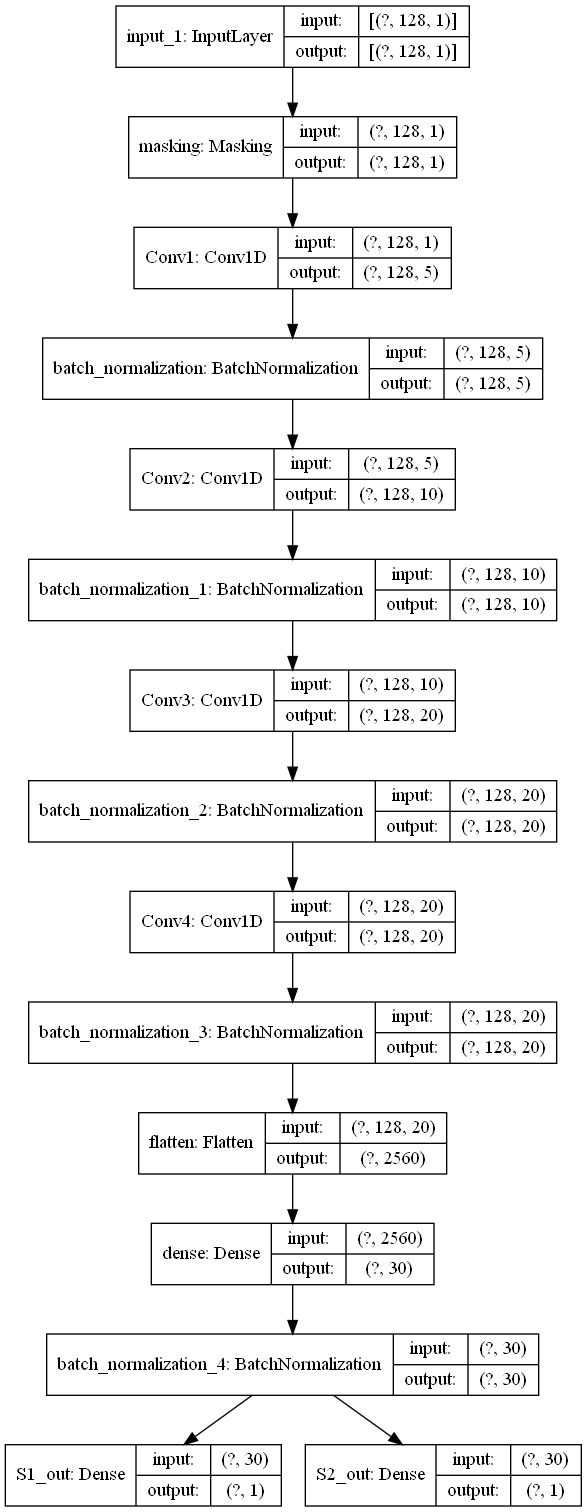

In [7]:
tf.keras.utils.plot_model(model, 'Model.png', show_shapes=True)

In [27]:
import pydot_ng as pydot
pydot.find_graphviz()

<IPython.core.display.Javascript object>


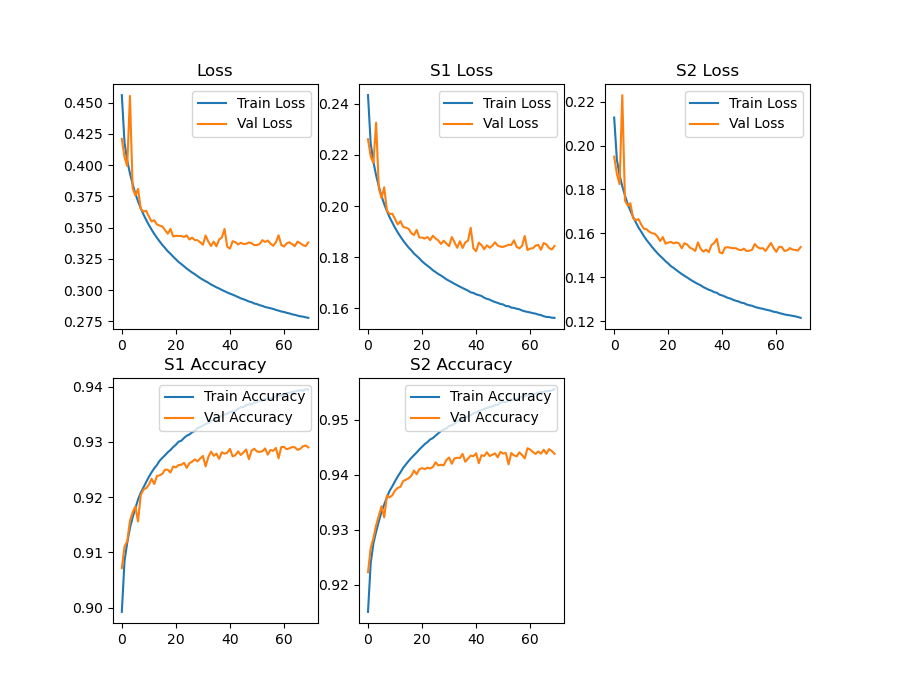

Test Results
------------
loss: 0.34316274523735046
s1 loss: 0.18819299340248108
s2 loss: 0.15496943891048431
s1 accuracy: 0.927901029586792
s2 accuracy: 0.9430730938911438


In [96]:
# Separando los resultados
train_info, test_info = model_results

%matplotlib notebook
plt.figure(figsize=(9,7))
plt.subplot(2,3,1)

plt.plot(train_info['loss'], label='Train Loss')
plt.plot(train_info['val_loss'], label='Val Loss')
plt.legend(loc='upper right')
plt.title('Loss')

plt.subplot(2,3,2)
plt.plot(train_info['S1_out_loss'], label='Train Loss')
plt.plot(train_info['val_S1_out_loss'], label='Val Loss')
plt.legend(loc='upper right')
plt.title('S1 Loss')

plt.subplot(2,3,3)
plt.plot(train_info['S2_out_loss'], label='Train Loss')
plt.plot(train_info['val_S2_out_loss'], label='Val Loss')
plt.legend(loc='upper right')
plt.title('S2 Loss')

plt.subplot(2,3,4)
plt.plot(train_info['S1_out_accuracy'], label='Train Accuracy')
plt.plot(train_info['val_S1_out_accuracy'], label='Val Accuracy')
plt.legend(loc='upper right')
plt.title('S1 Accuracy')

plt.subplot(2,3,5)
plt.plot(train_info['S2_out_accuracy'], label='Train Accuracy')
plt.plot(train_info['val_S2_out_accuracy'], label='Val Accuracy')
plt.legend(loc='upper right')
plt.title('S2 Accuracy')

plt.show()

# Entregando datos de los test
loss, s1_loss, s2_loss, s1_acc, s2_acc = test_info
print("Test Results\n------------")
print(f'loss: {loss}')
print(f's1 loss: {s1_loss}')
print(f's2 loss: {s2_loss}')
print(f's1 accuracy: {s1_acc}')
print(f's2 accuracy: {s2_acc}')

### Probar con datos de auscultación de sonidos respiratorios

In [101]:
# Obtención de los archivos de testeo
db_ultimate = 'HS_ultimate_test/Level 4'
# db_ultimate = 'PhysioNet 2016 CINC Heart Sound Database'
wav_files = [f'{db_ultimate}/{i}' for i in os.listdir(db_ultimate) if i.endswith('.wav')]

<IPython.core.display.Javascript object>


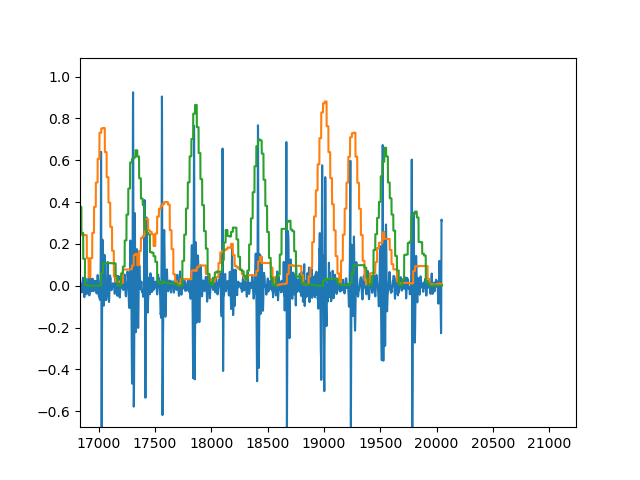

In [102]:
# Obtención de los datos del modelo entrenado a revisar
with open(f'Models/{model_name}-get_model_data_params.txt', 'r', encoding='utf8') as file:
    window_dict = literal_eval(file.readline())

# Cargando el archivo de audio
samplerate, audio = wavfile.read(wav_files[1])

audio = audio / max(abs(audio))

new_rate, dwns_signal = downsampling_signal(audio, samplerate, 
                                            freq_pass=450, 
                                            freq_stop=500)

audio_bp = bandpass_filter(dwns_signal, new_rate, 
                           freq_stop_1=20, freq_pass_1=40, 
                           freq_pass_2=200, freq_stop_2=220, 
                           bp_method='scipy_fir', normalize=True)

# Evaluando
%matplotlib notebook
if model_name in ['Model_2', 'Model_2_2']:
    s1_signal, s2_signal = evaluate_heart_sound(model, audio, samplerate, window_dict,
                                                plot_signals=False)

    plt.plot(audio_bp)
    plt.plot(s1_signal)
    plt.plot(s2_signal)
    plt.show()
    
elif model_name in ['Model_3']:
    hs_signal = evaluate_heart_sound(model, audio, samplerate, window_dict,
                                                plot_signals=False)

    plt.plot(audio_bp)
    plt.plot(hs_signal)
    plt.show()

<IPython.core.display.Javascript object>


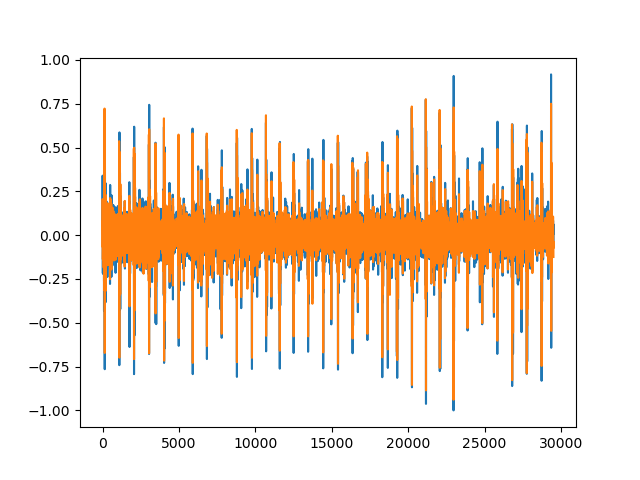

In [99]:
# Cargando el archivo de audio
audio, samplerate = sf.read(wav_files[1])

# Downsampling
new_rate, dwns_signal = downsampling_signal(audio, samplerate, 
                                            freq_pass=450, 
                                            freq_stop=500)

# Filtro pasa banda
audio_bp = bandpass_filter(dwns_signal, new_rate, 
                           freq_stop_1=20, freq_pass_1=40, 
                           freq_pass_2=200, freq_stop_2=220, 
                           bp_method='scipy_fir')

%matplotlib notebook
plt.plot(dwns_signal)
plt.plot(audio_bp)
plt.show()